In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
boc = BrainObservatoryCache()

# Cross session data

As many neurons are imaged across multiple session, many analyses require accessing data for those neurons from multiple data files. 

As mentioned in [Cell ids and indices](vc2p-session-data.md), when neurons are matched across multiple sessions they have the same <b>cell specimen id</b> but they have a different <b>cell index</b> within each session. 

Let's consider one neuron

In [3]:
cell_specimen_id = 517472450

We can find the sessions for which this neuron was recorded using the `get_ophys_experiments()` and passing a list that contains this cell specimen id.

In [4]:
#pd.DataFrame(boc.get_ophys_experiments(cell_specimen_ids=[cell_specimen_id]))

As we expect, all of these sessions are from the same <b>experiment container id</b> each from a different <b>session type</b>. If this is not clear, refer to [Experiment containers and session](experiment_containers_sessions).

Let's explore this neuron across all three sessions. First let's get the data for all three sessions.

In [5]:
id_a = boc.get_ophys_experiments(cell_specimen_ids=[cell_specimen_id], session_types=['three_session_A'])[0]['id']
id_b = boc.get_ophys_experiments(cell_specimen_ids=[cell_specimen_id], session_types=['three_session_B'])[0]['id']
id_c = boc.get_ophys_experiments(cell_specimen_ids=[cell_specimen_id], session_types=['three_session_C'])[0]['id']

#id_a = 501704220
#id_b = 501559087
#id_c = 501474098	

data_set_a = boc.get_ophys_experiment_data(id_a)
data_set_b = boc.get_ophys_experiment_data(id_b)
data_set_c = boc.get_ophys_experiment_data(id_c)

Let's find the cell index for this neuron in each of these sessions. Recall that there are different [cell indices](cell_ids_indices) for each session even thought the neuron has a single cell id.

In [6]:
index_a = data_set_a.get_cell_specimen_indices([cell_specimen_id])[0]
index_b = data_set_b.get_cell_specimen_indices([cell_specimen_id])[0]
index_c = data_set_c.get_cell_specimen_indices([cell_specimen_id])[0]

print("Session A index: ", str(index_a))
print("Session B index: ", str(index_b))
print("Session C index: ", str(index_c))

Session A index:  16
Session B index:  171
Session C index:  1


We can visualize the [maximum projection](maximum_projection) for each session and see the [ROI mask](roi_mask) of the neuron in each session.

(-0.5, 511.5, 511.5, -0.5)

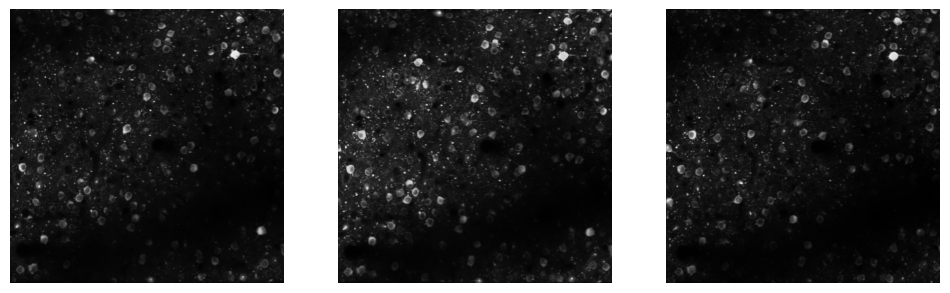

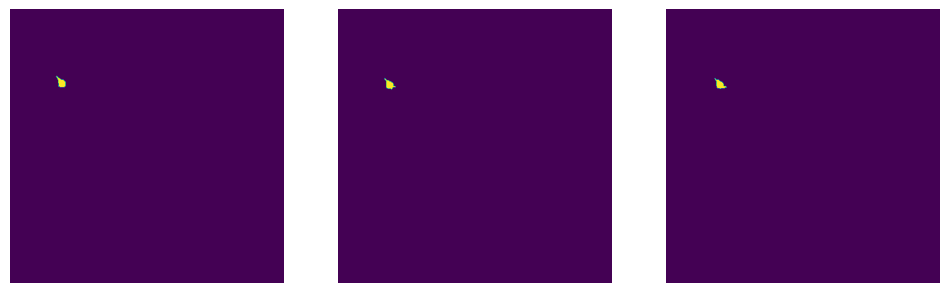

In [7]:
mp_a = data_set_a.get_max_projection()
mp_b = data_set_b.get_max_projection()
mp_c = data_set_c.get_max_projection()

rois_a = data_set_a.get_roi_mask_array()
rois_b = data_set_b.get_roi_mask_array()
rois_c = data_set_c.get_roi_mask_array()

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(131)
ax1.imshow(mp_a, cmap='gray')
ax1.axis('off')
ax2 = plt.subplot(132)
ax2.imshow(mp_b, cmap='gray')
ax2.axis('off')
ax3 = plt.subplot(133)
ax3.imshow(mp_c, cmap='gray')
ax3.axis('off')

fig2 = plt.figure(figsize=(12,5))
ax4 = plt.subplot(131)
ax4.imshow(rois_a[index_a,:,:])
ax4.axis('off')
ax5 = plt.subplot(132)
ax5.imshow(rois_b[index_b,:,:])
ax5.axis('off')
ax6 = plt.subplot(133)
ax6.imshow(rois_c[index_c,:,:])
ax6.axis('off')

Let's look at the activity of this neuron in each session. We'll use the DF/F.

Text(0, 0.5, 'DF/F (%)')

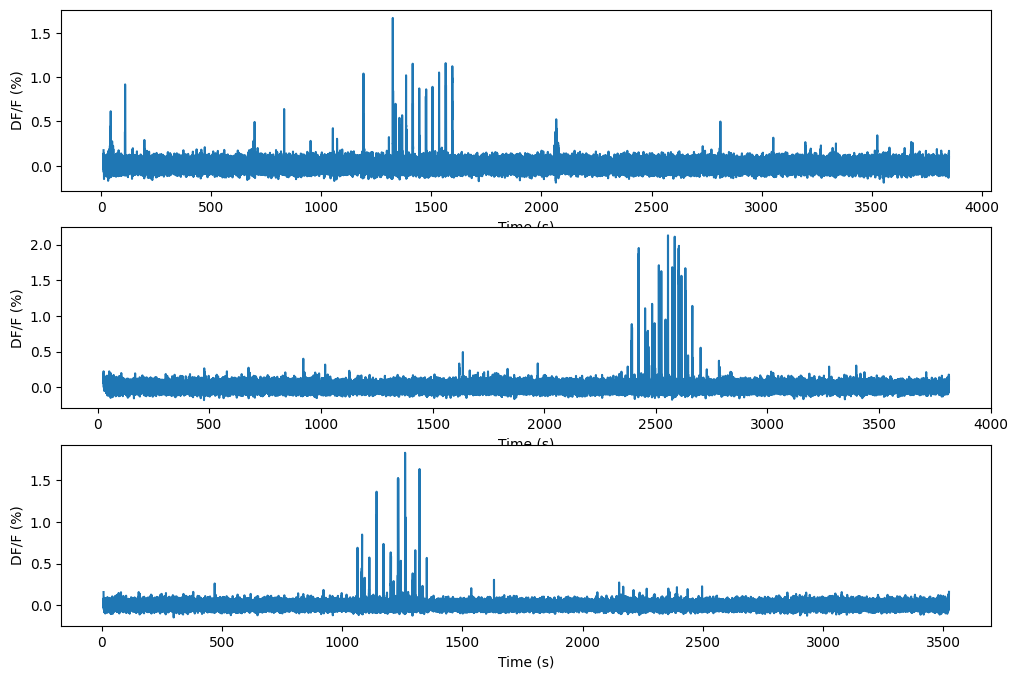

In [8]:
ts_a,dff_a = data_set_a.get_dff_traces()
ts_b,dff_b = data_set_b.get_dff_traces()
ts_c,dff_c = data_set_c.get_dff_traces()

plt.figure(figsize=(12,8))
ax1 = plt.subplot(311)
ax1.plot(ts_a,dff_a[index_a,:])
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("DF/F (%)")
ax2 = plt.subplot(312)
ax2.plot(ts_b,dff_b[index_b,:])
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("DF/F (%)")
ax3 = plt.subplot(313)
ax3.plot(ts_c,dff_c[index_c,:])
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("DF/F (%)")

Each experiment session consists of a different set of stimuli, but in each session has two things: at least one epoch of [spontaneous activity](spontaneous_activity) and [natural movie one](natural_movie).

Let's compute the mean response of this neuron's response to natural movie one in each session and compare them.

Text(0, 0.5, 'DF/F (%)')

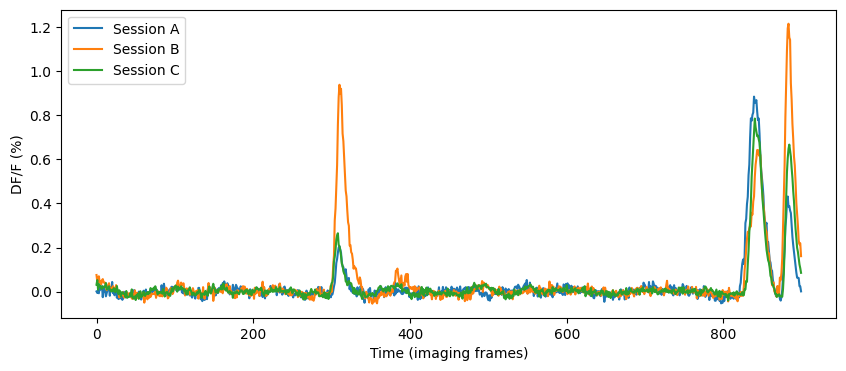

In [9]:
nm_stim_a = data_set_a.get_stimulus_table('natural_movie_one')
nm_stim_b = data_set_b.get_stimulus_table('natural_movie_one')
nm_stim_c = data_set_c.get_stimulus_table('natural_movie_one')

repeat_starts_a = nm_stim_a[nm_stim_a.frame==0].start.values
repeat_starts_b = nm_stim_b[nm_stim_b.frame==0].start.values 
repeat_starts_c = nm_stim_c[nm_stim_c.frame==0].start.values

nm_a = np.empty((900,10))
nm_b = np.empty((900,10))
nm_c = np.empty((900,10))
for i in range(10):
  start_a = repeat_starts_a[i]
  nm_a[:,i] = dff_a[index_a,start_a:start_a+900]
  start_b = repeat_starts_b[i]
  nm_b[:,i] = dff_b[index_b,start_b:start_b+900]
  start_c = repeat_starts_c[i]
  nm_c[:,i] = dff_c[index_c,start_c:start_c+900]

plt.figure(figsize=(10,4))
plt.plot(nm_a.mean(axis=1), label="Session A")
plt.plot(nm_b.mean(axis=1), label="Session B")
plt.plot(nm_c.mean(axis=1), label="Session C")

plt.legend()
plt.xlabel("Time (imaging frames)")
plt.ylabel("DF/F (%)")

How similar are these mean responses?

In [10]:
import scipy.stats as st
r,p = st.pearsonr(nm_a.mean(axis=1), nm_b.mean(axis=1))
print("AB Correlation = ", str(r))

r,p = st.pearsonr(nm_a.mean(axis=1), nm_c.mean(axis=1))
print("AC Correlation = ", str(r))

r,p = st.pearsonr(nm_b.mean(axis=1), nm_c.mean(axis=1))
print("BC Correlation = ", str(r))

AB Correlation =  0.6876919774041833
AC Correlation =  0.9028353266931375
BC Correlation =  0.8303760776176357
